# DCGANS

In [ ]:
""" 
Title : DCGANS - Deep Convolutional Generative Adveserial Neural Networks

API : Pytorch

Dataset : Custom dataset of flowers from kaggle : daisy class

Author : Srimanth Tenneti

Date : 20/06/2020

"""

### Importing libraries

In [1]:
import os # Helps us integrate code with the operating system
import random  # Helps in generating noise
import argparse  # Helps with the arguments

import torch # Pytorch and its other packages
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision.datasets as dset # Torchvision 
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np # Matrix operations

import matplotlib.pyplot as plt # Animation and visualization  
import matplotlib.animation as animation


### Defining the Parameters

In [2]:
dataroot = r"C:\Users\Srimanth Tenneti/Desktop/GANS/flowers" # Root directory of the dataset
workers = 2 # Numbers of workers for dataloader
batch_size = 128 # Batch size during training
image_size = 64
nc = 3 # Number of channels in training images. For color images it is 3
nz = 100 # Size of z latent vector (size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # size od feature maps in discriminator
num_epochs = 3 # Number of training epochs
lr = 0.0002 # Learning rate for the optimizers
beta1 = 0.5 # Beta1 hyperparameter for the Adam Optimizers

### Creating the dataset , applying suitable transforms , creating the dataloader and plottting some images randomly

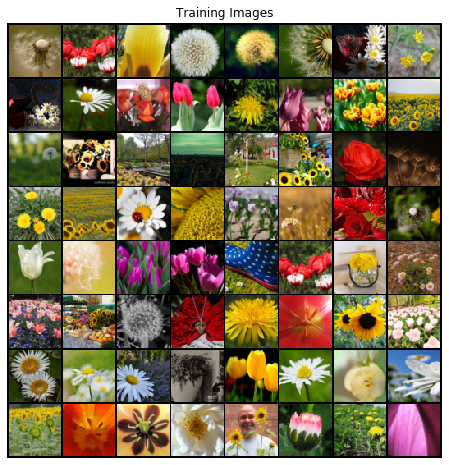

In [4]:
# Here we can use the image folder dataset the way we have it setup

# This is used for creating the dataset
dataset = dset.ImageFolder(root = dataroot,
                          transform = transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                          ]))

#creating the dataloader

dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers = workers)

# Setting target device

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plotting some images
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64] , padding=2 , normalize=True).cpu(),(1,2,0)))

### Initializing the weights 

In [5]:
# Custom weights initialization

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data , 0.0 , 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data , 1.0 , 0.02)
        nn.init.constant_(m.bias.data , 0)

### Generator 

In [ ]:
""" 
The generator can also be percieved as a De-Convolutional Neural Network. Here we pass a vector to the
generator as input and it results is an image as output. This is exactly opposite to the process in a
CNN (Convolutional Neural Network.)

Input size : 100
Output image size : 64x64x3


This is implemented via the 2d transpose convolutional layers.

Structure
---------

Input(100) -> 4x4:(1024)Conv1 -> 8x8:(512)Conv2 -> 16x16:(256)Conv3 -> 32x32:(128)Conv4 -> 64x64 

Stride : 2

"""

In [6]:
#Gernerator code

class Generator(nn.Module):
    def __init__(self):
        super(Generator , self).__init__()
        self.main = nn.Sequential(
            # Input Z is going into a Convolution
            # (inp,out,kernel_size,stride,padding,bias)
            nn.ConvTranspose2d(nz , ngf * 8 , 4 , 1 , 0 , bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # State Size (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8 , ngf * 4 ,4 , 2 ,  1  , bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # State Size (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4 , ngf * 2 , 4 , 2 , 1 , bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # State Size (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2 , ngf  , 4 , 2 , 1 , bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # State Size (nc) x 32 x 32
            nn.ConvTranspose2d(ngf , nc  , 4 , 2 , 1 , bias = False),
            nn.Tanh()          
            
            # State Size 64 x 64
            
        )
        
    def forward(self , input):
        return self.main(input)

In [7]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator  

In [8]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [9]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
criterion = nn.BCELoss() #Initialize the BCELoss

fixed_noise = torch.randn(64 , nz , 1 , 1 , device=device) #Creating the batch of latent vector

real_label = 1
fake_label = 0

#Setup Adam optimizer for both G and D
optimizerD = optim.Adam(netD.parameters(),lr=lr,betas = (beta1,0.999))
optimizerG = optim.Adam(netG.parameters(),lr=lr,betas = (beta1,0.999))

In [36]:
#Training loop

#Monitoring variable
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting the training ...\n")
for epoch in range(num_epochs):
    for i,data in enumerate(dataloader,0):
        # Update D Network : maximize log(D(x)) + log(1-D(G(z)))
        # Training with all real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,),real_label,device = device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output , label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Training with all fake batch
        noise = torch.randn(b_size,nz,1,1,device=device)
        #Generate fake image batch with data
        fake = netG(noise)
        label.fill_(fake_label)
        #Classify fake data with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss with all fake data
        errD_fake = criterion(output,label)
        #Calculating the gradients for the batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        #Add gradients from all real and all fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        # Updating generator maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) #fake labels are real for generator cost
        #Now we updated D, now fp -> fake batch through D
        output = netD(fake).view(-1)
        #Calculate G's loss
        errG = criterion(output,label)
        errG.backward()
        D_G_z2 = output.mean().item()
        #Update G
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        
        
        
        

Starting the training ...

[0/3][0/68]	Loss_D: 0.4487	Loss_G: 4.5692	D(x): 0.9037	D(G(z)): 0.2703 / 0.0149
[0/3][50/68]	Loss_D: 0.5300	Loss_G: 3.6321	D(x): 0.8621	D(G(z)): 0.2803 / 0.0400
[1/3][0/68]	Loss_D: 0.9090	Loss_G: 2.3783	D(x): 0.4716	D(G(z)): 0.0342 / 0.1255
[1/3][50/68]	Loss_D: 0.3727	Loss_G: 2.7077	D(x): 0.8453	D(G(z)): 0.1632 / 0.0883
[2/3][0/68]	Loss_D: 3.0604	Loss_G: 6.5990	D(x): 0.9943	D(G(z)): 0.9134 / 0.0046
[2/3][50/68]	Loss_D: 0.7005	Loss_G: 2.8170	D(x): 0.5658	D(G(z)): 0.0379 / 0.0984


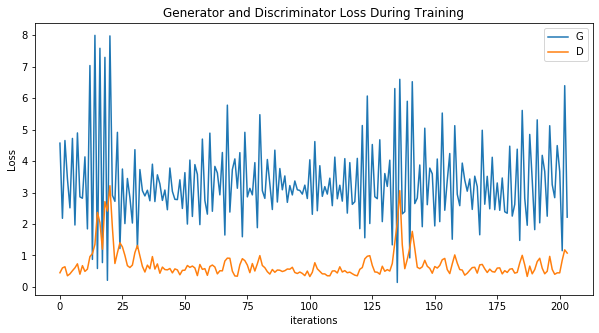

In [37]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[[<matplotlib.image.AxesImage at 0x1f51a65b8c8>],

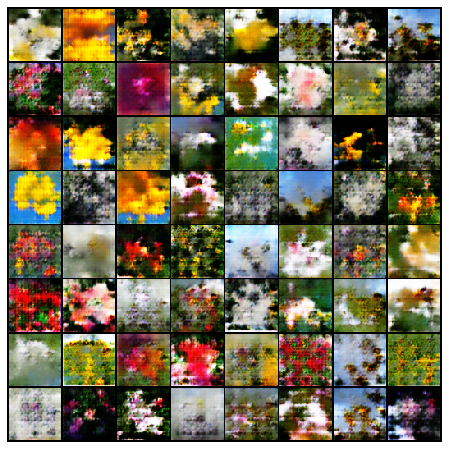

In [38]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ims

In [ ]:
""" Tensorboard Test """

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as dset
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [12]:
dataset = dset.MNIST('./root' ,download = True , train = True ,transform = transform)
trainset= dset.MNIST('./root' , download = True , train = False , transform = transform)

Extracting ./root\MNIST\raw\train-images-idx3-ubyte.gz to ./root\MNIST\raw


Extracting ./root\MNIST\raw\train-labels-idx1-ubyte.gz to ./root\MNIST\raw


Extracting ./root\MNIST\raw\t10k-images-idx3-ubyte.gz to ./root\MNIST\raw


Extracting ./root\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./root\MNIST\raw
Processing...
Done!


In [21]:
dataloader = torch.utils.data.DataLoader(dataset ,batch_size = 16, shuffle = True)
validloader = torch.utils.data.DataLoader(trainset ,batch_size = 16, shuffle = True)
device = torch.device("cuda:0"  if  torch.cuda.is_available() else "cpu")

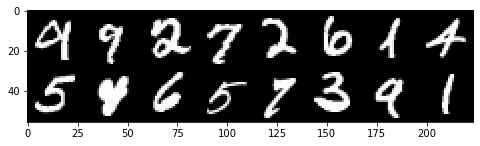

In [28]:
data = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.imshow(np.transpose(torchvision.utils.make_grid(data[0].to(device)[:64] , padding=0 , normalize=True).cpu(),(1,2,0)))

In [ ]:
class net(nn.Module):
    def __init__(self):
        super(net , self).__init__()
        
        self.conv1 = nn.Conv2d(1 , 10 ,  )
        self.conv2 = nn.Conv2d()